In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import numba
import glob
import sys
from scipy.optimize import curve_fit

sys.path.insert(0, "/mnt/ssd1/Documents/Vivek/MalkoFish/MalkoAnalyzer")
import swarm
import BaseToolbox as bt
import plotBox as pb
import plotter
import copy
import cv2
from imp import reload

reload(pb)
reload(plotter)
reload(bt)

plotter.pb.boxSize.defineBoxSize((-5, 5), (-5, 5), (-1, 1))
plotter.pb.boxSizeRelative.defineBoxSize((-10, 10), (-10, 10), (-1, 1))

In [2]:
dataDIR = "/media/user/Samsung_T3/Work/Documents/Data/flyVR/new_experiments/"
projectDB = "/mnt/ssd1/Documents/Vivek/flyVR/fly-matrix/dbGen/flyProjects.db"
expDB = "/mnt/ssd1/Documents/Vivek/flyVR/fly-matrix/dbGen/flyExperiments.db"


nPosts = 2
long_ev = True
window_size = 20 if nPosts == 2 else 30
spatial_discretisation_step = 0.01

In [3]:
def rotate(xy, radians):
    x, y = xy
    c, s = np.cos(radians), np.sin(radians)
    j = np.matrix([[c, s], [-s, c]])
    m = np.dot(j, [x, y])

    return m

In [4]:
# establish a connecttion to the project database
conn = sqlite3.connect(projectDB)
# connect a cursor that goes through the project database
cursorProject = conn.cursor()
# establish a second connecttion to the experiment database
conn2 = sqlite3.connect(expDB)
# connect a cursor that goes through the experiment database
cursorExperiment = conn2.cursor()

# pick experiments from specified project
cursorExperiment.execute(
    "Select expId from experiments where project = ? and exp >= ? and exp < ?",
    ("DecisionGeometry", (nPosts - 2) * 10, (nPosts - 1) * 10),
)
fetched = cursorExperiment.fetchall()
print("fetched : " + str(fetched))

fetched : [('7b035fd1-bf5d-4b17-b07b-fdce31c00174',), ('0cac2ffa-751c-47e2-a60c-a4394f0c3694',), ('730e9871-40e2-49f2-951e-64ee4c6a264b',), ('14aa360d-a93c-4c1c-bfa4-fe3d46fea4fe',), ('ae62bd32-c787-4ace-af5e-5602fd41c6de',), ('7b78ebae-f5d9-45b1-8a06-64ef4ac1be26',), ('32b3e6c4-0254-4a34-a89f-b4511f867a43',), ('be8d0ed4-cb4d-4be1-9197-ed3070a2d6c0',), ('02729761-34f5-47d3-853d-24d44b95e01a',), ('e5009561-0dc8-45a3-80d9-e23619ae9f63',), ('766cebfa-ec3a-45ae-bee8-c45b9af7e890',), ('811f4e3f-e84a-44fa-9aa2-c4cc5452b6b1',), ('b3122f45-b25b-49ab-994f-de87d61cd420',), ('38940006-4529-46a0-a368-e732cd684c29',), ('e02e2fb4-c50e-4d72-bd5e-f64e24bd718c',), ('4bc09102-9e80-4b75-9162-bfe947b89847',), ('4c934967-64bd-421e-9f00-cc017df1d6cd',), ('a7df1714-2578-469d-afc2-712db8adeac0',), ('d8794167-49af-44a7-8ade-cbe6dafcd718',), ('85e8dae9-3b21-42bb-8d27-b57d411cb94c',), ('eb518d61-f816-488f-98d0-400a5d6778b6',), ('a9ffea1b-5e11-4026-ae8c-3b6e13d52619',), ('33993c50-c962-4e8f-8142-ae85cb2079b1',), 

In [5]:
angles = []
dataDict0 = []
dataDict1 = []
dataDict2 = []
rot_post0 = []
for uuid in range(0, len(fetched)):
    cursorExperiment.execute(
        "Select exp from experiments where expId = ?", (fetched[uuid][0],)
    )
    fetch_exp = cursorExperiment.fetchall()[0][0]
    cursorExperiment.execute(
        "Select replicate from experiments where expId = ?", (fetched[uuid][0],)
    )
    fetch_rep = cursorExperiment.fetchall()[0][0]

    cursorProject.execute(
        "Select post0 from projects where project = ? and exp = ? and replicate = ?",
        ("DecisionGeometry", fetch_exp, fetch_rep),
    )
    dataDict0.append(cursorProject.fetchall())
    cursorProject.execute(
        "Select post1 from projects where project = ? and exp = ? and replicate = ?",
        ("DecisionGeometry", fetch_exp, fetch_rep),
    )
    dataDict1.append(cursorProject.fetchall())
    cursorProject.execute(
        "Select post2 from projects where project = ? and exp = ? and replicate = ?",
        ("DecisionGeometry", fetch_exp, fetch_rep),
    )
    dataDict2.append(cursorProject.fetchall())

    tmp = pd.read_csv(
        dataDIR + fetched[uuid][0] + "/results.csv",
        names=["x", "y", "z", "dir", "event", "t", "nStimuli"],
    )
    tmp["uuid"] = uuid
    tmp["post0_x"] = tmp["post0_y"] = tmp["post1_x"] = tmp["post1_y"] = np.nan
    if nPosts == 3:
        tmp["post2_x"] = tmp["post2_y"] = np.nan

    tmp3 = pd.DataFrame(
        columns=[
            "x",
            "y",
            "z",
            "dir",
            "event",
            "t",
            "nStimuli",
            "uuid",
            "post0_x",
            "post0_y",
            "post1_x",
            "post1_y",
        ]
    )
    for i in np.unique(tmp["nStimuli"]):
        for j in np.unique(tmp.loc[tmp["nStimuli"] == i, "event"]):
            tmp2 = tmp.loc[(tmp["nStimuli"] == i) & (tmp["event"] == j), :]
            tmp2 = tmp2.reset_index()
            tmp2["selected"] = 0

            start_x = tmp2.loc[0, "x"]
            start_y = tmp2.loc[0, "y"]
            for k in range(1, len(tmp2)):
                x = tmp2.loc[k, "x"]
                y = tmp2.loc[k, "y"]
                dist = np.sqrt((start_x - x) ** 2 + (start_y - y) ** 2)
                if dist > spatial_discretisation_step:
                    tmp2.loc[k, "selected"] = 1
                    start_x = x
                    start_y = y
            tmp3 = tmp3.append(tmp2[tmp2["selected"] == 1])

    df = tmp3 if uuid == 0 else pd.concat([df, tmp3])
    rot_post0.append([eval(dataDict0[uuid][1][0])["distance"], 0.0])

    cursorProject.execute(
        "Select post1 from projects where project = ? and exp >= ? and exp < ?",
        ("DecisionGeometry", (nPosts - 2) * 10, (nPosts - 1) * 10),
    )
    for a in np.unique(cursorProject.fetchall()):
        if a != "None" and eval(a)["angle"] not in angles:
            angles.append(eval(a)["angle"])

angles = np.sort(np.array(angles))

/home/user/.local/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [6]:
# add post positions to dataframe
nStimuli = np.unique(df["nStimuli"])
for uuid in range(0, len(fetched)):
    for i in range(0, np.max(nStimuli) + 1):
        df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "post0_x"] = eval(
            dataDict0[uuid][nStimuli[i]][0]
        )["position"][0]
        df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "post0_y"] = eval(
            dataDict0[uuid][nStimuli[i]][0]
        )["position"][1]
        if i > 0 and i < np.max(nStimuli):
            df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "post1_x"] = eval(
                dataDict1[uuid][nStimuli[i]][0]
            )["position"][0]
            df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "post1_y"] = eval(
                dataDict1[uuid][nStimuli[i]][0]
            )["position"][1]
            if nPosts == 3:
                df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "post2_x"] = eval(
                    dataDict2[uuid][nStimuli[i]][0]
                )["position"][0]
                df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "post2_y"] = eval(
                    dataDict2[uuid][nStimuli[i]][0]
                )["position"][1]
            df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "angle"] = eval(
                dataDict1[uuid][nStimuli[i]][0]
            )["angle"]

# initialise rotation of tracks and posts
df["rotated_x"] = df["rotated_y"] = 0.0
df["rotated_post0_x"] = df["rotated_post0_y"] = df["rotated_post1_x"] = df[
    "rotated_post1_y"
] = 0.0
if nPosts == 3:
    df["rotated_post2_x"] = df["rotated_post2_y"] = 0.0
df["ang"] = 0.0

In [7]:
# get rotation angle
for uuid in range(0, len(fetched)):
    rot_post0_x = rot_post0[uuid][0]
    rot_post0_y = rot_post0[uuid][1]
    df.loc[df["uuid"] == uuid, "ang"] = np.arctan2(
        df.loc[df["uuid"] == uuid, "post0_y"], df.loc[df["uuid"] == uuid, "post0_x"]
    )

# rotate tracks and posts (posts are now centred along positive x-axis)
for uuid in range(0, len(fetched)):
    for i in range(0, np.max(nStimuli) + 1):
        ang = np.unique(df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "ang"])[0]
        if i > 0 and i < np.max(nStimuli):
            ang += (nPosts - 1) * eval(dataDict0[uuid][nStimuli[i]][0])["angle"] / 2

        rx, ry = rotate(
            np.array(
                (
                    df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "x"],
                    df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "y"],
                )
            ),
            ang,
        )
        df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "rotated_x"] = np.squeeze(
            np.asarray(rx.T)
        )
        df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "rotated_y"] = np.squeeze(
            np.asarray(ry.T)
        )

        rp0x, rp0y = rotate(
            np.array(
                (
                    df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "post0_x"],
                    df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "post0_y"],
                )
            ),
            ang,
        )
        df.loc[
            (df["uuid"] == uuid) & (df["nStimuli"] == i), "rotated_post0_x"
        ] = np.squeeze(np.asarray(rp0x.T))
        df.loc[
            (df["uuid"] == uuid) & (df["nStimuli"] == i), "rotated_post0_y"
        ] = np.squeeze(np.asarray(rp0y.T))

        rp1x, rp1y = rotate(
            np.array(
                (
                    df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "post1_x"],
                    df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "post1_y"],
                )
            ),
            ang,
        )
        df.loc[
            (df["uuid"] == uuid) & (df["nStimuli"] == i), "rotated_post1_x"
        ] = np.squeeze(np.asarray(rp1x.T))
        df.loc[
            (df["uuid"] == uuid) & (df["nStimuli"] == i), "rotated_post1_y"
        ] = np.squeeze(np.asarray(rp1y.T))

        if nPosts == 3:
            rp2x, rp2y = rotate(
                np.array(
                    (
                        df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "post2_x"],
                        df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == i), "post2_y"],
                    )
                ),
                ang,
            )
            df.loc[
                (df["uuid"] == uuid) & (df["nStimuli"] == i), "rotated_post2_x"
            ] = np.squeeze(np.asarray(rp2x.T))
            df.loc[
                (df["uuid"] == uuid) & (df["nStimuli"] == i), "rotated_post2_y"
            ] = np.squeeze(np.asarray(rp2y.T))

In [8]:
p0_dist = np.sqrt((df["x"] - df["post0_x"]) ** 2 + (df["y"] - df["post0_y"]) ** 2)
p1_dist = np.sqrt((df["x"] - df["post1_x"]) ** 2 + (df["y"] - df["post1_y"]) ** 2)
if nPosts == 2:
    df["dmin"] = np.nanmin([p0_dist, p1_dist], axis=0)
    df["post"] = 0
    df.loc[p1_dist < p0_dist, "post"] = 1
else:
    p2_dist = np.sqrt((df["x"] - df["post2_x"]) ** 2 + (df["y"] - df["post2_y"]) ** 2)
    df["dmin"] = np.nanmin([p0_dist, p1_dist, p2_dist], axis=0)
    df["post"] = 0
    df.loc[(p1_dist < p0_dist) & (p1_dist < p2_dist), "post"] = 1
    df.loc[(p2_dist < p0_dist) & (p2_dist < p1_dist), "post"] = 2

In [9]:
tmax = df.loc[:, ["uuid", "nStimuli", "event", "t"]]
tmax = tmax.groupby(["uuid", "nStimuli", "event"]).max().reset_index()
dmin = df.loc[:, ["uuid", "nStimuli", "event", "t", "dmin", "post", "angle"]]

dists = pd.merge(tmax, dmin, how="left")
dists = dists[dists["dmin"] < 0.8]

if nPosts == 2:
    fly_idx = dists.loc[dists['angle'] == np.unique(dmin['angle'].dropna())[0], 'uuid']
else:
    fly_idx = dists.loc[dists['angle'] == np.unique(dmin['angle'].dropna())[1], 'uuid']
fly_idx = fly_idx.reset_index()['uuid']

dists = dists.loc[:, ["uuid", "nStimuli", "event"]]

df = pd.merge(dists, df, how="left")

In [10]:
for i1, u in enumerate(np.unique(df["uuid"])):
    tmp = df[df["uuid"] == u]
    for i2, n in enumerate(np.unique(tmp["nStimuli"])):
        tmp2 = tmp[tmp["nStimuli"] == n]
        for i3, e in enumerate(np.unique(tmp2["event"])):
            df.loc[
                (df["uuid"] == u) & (df["nStimuli"] == n) & (df["event"] == e), "uuid"
            ] = i1
            df.loc[
                (df["uuid"] == u) & (df["nStimuli"] == n) & (df["event"] == e),
                "nStimuli",
            ] = i2
            df.loc[
                (df["uuid"] == u) & (df["nStimuli"] == n) & (df["event"] == e), "event"
            ] = i3

In [11]:
### establish a connecttion to the project database
conn = sqlite3.connect(projectDB)
# connect a cursor that goes through the project database
cursorProject = conn.cursor()
# establish a second connecttion to the experiment database
conn2 = sqlite3.connect(expDB)
# connect a cursor that goes through the experiment database
cursorExperiment = conn2.cursor()


x = df[["rotated_x", "rotated_y"]].values
x = np.c_[x, x[:, 0] * 0]
x_Post0 = df[["rotated_post0_x", "rotated_post0_y"]].values
x_Post0 = np.c_[x_Post0, x_Post0[:, 0] * 0]
x_Post1 = df[["rotated_post1_x", "rotated_post1_y"]].values
x_Post1 = np.c_[x_Post1, x_Post1[:, 0] * 0]
if nPosts == 3:
    x_Post2 = df[["rotated_post2_x", "rotated_post2_y"]].values
    x_Post2 = np.c_[x_Post2, x_Post2[:, 0] * 0]
t = df["t"].values
uuids = df["uuid"].values
nStimuli = df["nStimuli"].values
events = df["event"].values
print(x.shape)

(311341, 3)


In [12]:
massive_experiment = swarm.Swarm()
for i in range(0, len(angles) + 2):
    massive_experiment.addFish(swarm.Swarm())

for uuid in range(0, len(fetched)):
    cursorExperiment.execute(
        "Select exp from experiments where expID = ?", (fetched[uuid][0],)
    )
    exp = cursorExperiment.fetchall()
    nSt = len(np.unique(df.loc[df["uuid"] == uuid, "nStimuli"]))
    for n in range(0, nSt):
        stimuli = swarm.Swarm()
        nEvents = len(
            np.unique(df.loc[(df["uuid"] == uuid) & (df["nStimuli"] == n), "event"])
        )
        if nEvents == 0:
            print(uuid, n)
        for e in range(0, nEvents):
            event = swarm.Swarm()
            idx = np.where((uuids == uuid) & (nStimuli == n) & (events == e))[0]
            if len(idx) > 30:
                event.addFish(
                    swarm.Fish(x, t, idx=idx, burst=False, fishId=0, virtual=False)
                )
                event.addFish(
                    swarm.Fish(x_Post0, t, idx=idx, burst=False, fishId=1, virtual=True)
                )
                if n != 0 and n != np.max(nStimuli):
                    event.addFish(
                        swarm.Fish(
                            x_Post1, t, idx=idx, burst=False, fishId=2, virtual=True
                        )
                    )
                    if nPosts > 2:
                        event.addFish(
                            swarm.Fish(
                                x_Post2, t, idx=idx, burst=False, fishId=3, virtual=True
                            )
                        )
                event.fishReferential()
                stimuli.addFish(event)
        if n == 0:
            massive_experiment.swarm[n].addFish(stimuli)
        elif n == np.max(nStimuli):
            massive_experiment.swarm[len(angles) + 1].addFish(stimuli)
        else:
            cursorExperiment.execute(
                "Select replicate from experiments where expID = ?", (fetched[uuid][0],)
            )
            rep = cursorExperiment.fetchall()
            cursorProject.execute(
                "Select post1 from projects where project = ? and exp = ? and replicate = ? and nStimuli = ?",
                ("DecisionGeometry", exp[0][0], rep[0][0], n),
            )
            post = cursorProject.fetchall()
            s_number = np.where(angles == eval(post[0][0])["angle"])[0][0]
            massive_experiment.swarm[s_number + 1].addFish(stimuli)

for i in range(0, len(angles) + 2):
    massive_experiment.swarm[i].fillMetaFish()

all_experiments = swarm.Swarm()
all_experiments.addFish(massive_experiment)

/mnt/ssd1/Documents/Vivek/MalkoFish/MalkoAnalyzer/BaseToolbox.py:314: RuntimeWarning: invalid value encountered in true_divide
  v2 = v2 / (np.linalg.norm(v2, axis=1))[:, None]
/mnt/ssd1/Documents/Vivek/MalkoFish/MalkoAnalyzer/BaseToolbox.py:313: RuntimeWarning: invalid value encountered in true_divide
  v1 = v1 / (np.linalg.norm(v1, axis=1))[:, None]


In [13]:
if nPosts == 2:
    df = pd.DataFrame(
        np.concatenate(
            (
                all_experiments.get((0, 1)).metaFish["x"][:, 0][:, np.newaxis],
                all_experiments.get((0, 1)).metaFish["x"][:, 1][:, np.newaxis],
                all_experiments.get((0, 1)).metaFish["t"][:, np.newaxis],
            ),
            axis=1,
        ),
        columns=["x", "y", "t"],
    )
else:
    df = pd.DataFrame(
        np.concatenate(
            (
                all_experiments.get((0, 2)).metaFish["x"][:, 0][:, np.newaxis],
                all_experiments.get((0, 2)).metaFish["x"][:, 1][:, np.newaxis],
                all_experiments.get((0, 2)).metaFish["t"][:, np.newaxis],
            ),
            axis=1,
        ),
        columns=["x", "y", "t"],
    )

df["event"] = 0

 -- Architecture --


In [14]:
t = df.loc[0, "t"]
df.loc[0, "t"] = df.loc[0, "t"] - t
df.loc[0, "uuid"] = 0

idx = 0
for i in range(1, df.shape[0]):
    if (
        np.sqrt(
            (df.loc[i, "x"] - df.loc[i - 1, "x"]) ** 2
            + (df.loc[i, "y"] - df.loc[i - 1, "y"]) ** 2
        )
        < 0.5
    ):
        df.loc[i, "event"] = df.loc[i - 1, "event"]
        df.loc[i, "t"] = df.loc[i, "t"] - t
        df.loc[i, "uuid"] = fly_idx[idx]
    else:
        df.loc[i, "event"] = df.loc[i - 1, "event"] + 1
        t = df.loc[i, "t"]
        idx += 1
        
        df.loc[i, "uuid"] = fly_idx[idx]
        df.loc[i, "t"] = df.loc[i, "t"] - t

In [15]:
df['short'] = 0

if nPosts == 2:
    long_events = list(np.unique(df.loc[df["t"] > 26.5, "event"]))
else:
    long_events = list(np.unique(df.loc[df["t"] > 24.5, "event"]))

df.loc[~df["event"].isin(long_events), 'short'] = 1

In [16]:
df_events = df.loc[:,['uuid', 'event', 'short']]
df_events = df_events.drop_duplicates()

df_events = df_events.groupby(['uuid','short']).count().reset_index()

In [17]:
short = np.zeros(len(np.unique(df_events['uuid'])))
long = np.zeros(len(np.unique(df_events['uuid'])))

for idx in np.unique(df_events['uuid']):
    if df_events.loc[(df_events['uuid'] == idx) & (df_events['short'] == 0), 'event'].values.size != 0:
        long[int(idx)] = df_events.loc[(df_events['uuid'] == idx) & (df_events['short'] == 0), 'event'].values[0]
    if df_events.loc[(df_events['uuid'] == idx) & (df_events['short'] == 1), 'event'].values.size != 0:
        short[int(idx)] = df_events.loc[(df_events['uuid'] == idx) & (df_events['short'] == 1), 'event'].values[0]

total = short+long
short = short/total
long = long/total

findfont: Font family ['Glacial Indifference'] not found. Falling back to DejaVu Sans.


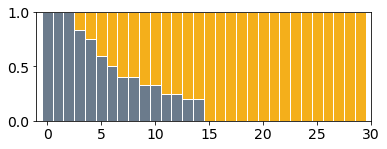

In [18]:
short_asc = short.argsort()
short = short[short_asc[::-1]]
long = long[short_asc[::-1]]

barWidth = 1

fig,ax = plt.subplots(1,1,figsize=(6,2))
ax.bar(np.unique(df['uuid']), short, color='#6b7b8c', edgecolor='white', width=barWidth)
ax.bar(np.unique(df['uuid']), long, bottom=short, color='#f4af1b', edgecolor='white', width=barWidth)
ax.set_xlim(-1,np.max(np.unique(df['uuid']))+1)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

fig.savefig("/mnt/ssd1/Documents/Vivek/flyVR/fly-matrix/figures/"+ str(nPosts)+ "_post_directedness.pdf",
    dpi=300, bbox_inches="tight")

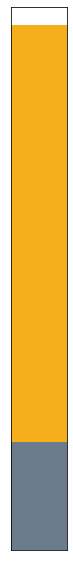

In [19]:
fig,ax = plt.subplots(1,1,figsize=(1,10))
ax.bar(0, len(short[short>0.5])/len(short), color='#6b7b8c')
ax.bar(0, len(long[long>0.5])/len(long), bottom=len(short[short>0.5])/len(short), color='#f4af1b')
ax.set_xlim(0,0.2)
ax.set_ylim(0,1)
ax.set_xticks([])
ax.set_yticks([])

fig.savefig("/mnt/ssd1/Documents/Vivek/flyVR/fly-matrix/figures/"+ str(nPosts)+ "_post_directedness_prop.pdf",
    dpi=300, bbox_inches="tight")